# Ensembling

*Adapted from Chapter 8 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)*

Why are we learning about ensembling?

- Very popular method for improving the predictive performance of machine learning models
- Provides a foundation for understanding more sophisticated models

## Lesson objectives

Students will be able to:

- Define ensembling and its requirements
- Identify the two basic methods of ensembling
- Decide whether manual ensembling is a useful approach for a given problem
- Explain bagging and how it can be applied to decision trees
- Explain how out-of-bag error and feature importances are calculated from bagged trees
- Explain the difference between bagged trees and Random Forests
- Build and tune a Random Forest model in scikit-learn
- Decide whether a decision tree or a Random Forest is a better model for a given problem

# Part 1: Introduction

Let's pretend that instead of building a single model to solve a binary classification problem, you created **five independent models**, and each model was correct about 70% of the time. If you combined these models into an "ensemble" and used their majority vote as a prediction, how often would the ensemble be correct?

In [3]:
import numpy as np

# set a seed for reproducibility
np.random.seed(1234)

# generate 1000 random numbers (between 0 and 1) for each model, representing 1000 observations
mod1 = np.random.rand(1000)
mod2 = np.random.rand(1000)
mod3 = np.random.rand(1000)
mod4 = np.random.rand(1000)
mod5 = np.random.rand(1000)

# each model independently predicts 1 (the "correct response") if random number was at least 0.3
preds1 = np.where(mod1 > 0.3, 1, 0)
preds2 = np.where(mod2 > 0.3, 1, 0)
preds3 = np.where(mod3 > 0.3, 1, 0)
preds4 = np.where(mod4 > 0.3, 1, 0)
preds5 = np.where(mod5 > 0.3, 1, 0)

# print the first 20 predictions from each model
print preds1[:20]
print preds2[:20]
print preds3[:20]
print preds4[:20]
print preds5[:20]

[0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1]
[1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0]
[1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1]
[1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0]
[0 0 1 0 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1]


In [4]:
# average the predictions and then round to 0 or 1
ensemble_preds = np.round((preds1 + preds2 + preds3 + preds4 + preds5)/5.0).astype(int)

# print the ensemble's first 20 predictions
print ensemble_preds[:20]

[1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1]


In [5]:
# how accurate was each individual model?
print preds1.mean()
print preds2.mean()
print preds3.mean()
print preds4.mean()
print preds5.mean()

0.713
0.665
0.717
0.712
0.687


In [6]:
# how accurate was the ensemble?
print ensemble_preds.mean()

0.841


**Note:** As you add more models to the voting process, the probability of error decreases, which is known as [Condorcet's Jury Theorem](http://en.wikipedia.org/wiki/Condorcet%27s_jury_theorem).

## What is ensembling?

**Ensemble learning (or "ensembling")** is the process of combining several predictive models in order to produce a combined model that is more accurate than any individual model.

- **Regression:** take the average of the predictions
- **Classification:** take a vote and use the most common prediction, or take the average of the predicted probabilities

For ensembling to work well, the models must have the following characteristics:

- **Accurate:** they outperform the null model
- **Independent:** their predictions are generated using different processes

**The big idea:** If you have a collection of individually imperfect (and independent) models, the "one-off" mistakes made by each model are probably not going to be made by the rest of the models, and thus the mistakes will be discarded when averaging the models.

There are two basic **methods for ensembling:**

- Manually ensemble your individual models
- Use a model that ensembles for you

# Part 2: Manual ensembling

What makes a good manual ensemble?

- Different types of **models**
- Different combinations of **features**
- Different **tuning parameters**

![Machine learning flowchart](images/crowdflower_ensembling.jpg)

*Machine learning flowchart created by the [winner](https://github.com/ChenglongChen/Kaggle_CrowdFlower) of Kaggle's [CrowdFlower competition](https://www.kaggle.com/c/crowdflower-search-relevance)*

## Comparing manual ensembling with a single model approach

**Advantages of manual ensembling:**

- Increases predictive accuracy
- Easy to get started

**Disadvantages of manual ensembling:**

- Decreases interpretability
- Takes longer to train
- Takes longer to predict
- More complex to automate and maintain
- Small gains in accuracy may not be worth the added complexity

# Part 3: Bagging

The primary weakness of **decision trees** is that they don't tend to have the best predictive accuracy. This is partially due to **high variance**, meaning that different splits in the training data can lead to very different trees.

**Bagging** is a general purpose procedure for reducing the variance of a machine learning method, but is particularly useful for decision trees. Bagging is short for **bootstrap aggregation**, meaning the aggregation of bootstrap samples.

What is a **bootstrap sample**? A random sample with replacement:

In [7]:
# set a seed for reproducibility
np.random.seed(1)

# create an array of 1 through 20
nums = np.arange(1, 21)
print nums

# sample that array 20 times with replacement
print np.random.choice(a=nums, size=20, replace=True)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 6 12 13  9 10 12  6 16  1 17  2 13  8 14  7 19  6 19 12 11]


**How does bagging work (for decision trees)?**

1. Grow B trees using B bootstrap samples from the training data.
2. Train each tree on its bootstrap sample and make predictions.
3. Combine the predictions:
    - Average the predictions for **regression trees**
    - Take a vote for **classification trees**

Notes:

- **Each bootstrap sample** should be the same size as the original training set.
- **B** should be a large enough value that the error seems to have "stabilized".
- The trees are **grown deep** so that they have low bias/high variance.

Bagging increases predictive accuracy by **reducing the variance**, similar to how cross-validation reduces the variance associated with train/test split (for estimating out-of-sample error) by splitting many times an averaging the results.

## Manually implementing bagged decision trees (with B=10)

In [8]:
# read in and prepare the vehicle training data
import pandas as pd
url = '../data/vehicles_train.csv'
train = pd.read_csv(url)
train['vtype'] = train.vtype.map({'car':0, 'truck':1})
train

,price,year,miles,doors,vtype
0,22000,2012,13000,2,0
1,14000,2010,30000,2,0
2,13000,2010,73500,4,0
3,9500,2009,78000,4,0
4,9000,2007,47000,4,0
5,4000,2006,124000,2,0
6,3000,2004,177000,4,0
7,2000,2004,209000,4,1
8,3000,2003,138000,2,0
9,1900,2003,160000,4,0


In [9]:
# set a seed for reproducibility
np.random.seed(123)

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=14, size=14, replace=True) for _ in range(1, 11)]
samples

[array([13,  2, 12,  2,  6,  1,  3, 10, 11,  9,  6,  1,  0,  1]),
 array([ 9,  0,  0,  9,  3, 13,  4,  0,  0,  4,  1,  7,  3,  2]),
 array([ 4,  7,  2,  4,  8, 13,  0,  7,  9,  3, 12, 12,  4,  6]),
 array([ 1,  5,  6, 11,  2,  1, 12,  8,  3, 10,  5,  0, 11,  2]),
 array([10, 10,  6, 13,  2,  4, 11, 11, 13, 12,  4,  6, 13,  3]),
 array([10,  0,  6,  4,  7, 11,  6,  7,  1, 11, 10,  5,  7,  9]),
 array([ 2,  4,  8,  1, 12,  2,  1,  1,  3, 12,  5,  9,  0,  8]),
 array([11,  1,  6,  3,  3, 11,  5,  9,  7,  9,  2,  3, 11,  3]),
 array([ 3,  8,  6,  9,  7,  6,  3,  9,  6, 12,  6, 11,  6,  1]),
 array([13, 10,  3,  4,  3,  1, 13,  0,  5,  8, 13,  6, 11,  8])]

In [10]:
# show the rows for the first decision tree
train.iloc[samples[0], :]

,price,year,miles,doors,vtype
13,1300,1997,138000,4,0
2,13000,2010,73500,4,0
12,1800,1999,163000,2,1
2,13000,2010,73500,4,0
6,3000,2004,177000,4,0
1,14000,2010,30000,2,0
3,9500,2009,78000,4,0
10,2500,2003,190000,2,1
11,5000,2001,62000,4,0
9,1900,2003,160000,4,0


In [11]:
# read in and prepare the vehicle testing data
url = '../data/vehicles_test.csv'
test = pd.read_csv(url)
test['vtype'] = test.vtype.map({'car':0, 'truck':1})
test

,price,year,miles,doors,vtype
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


In [12]:
from sklearn.tree import DecisionTreeRegressor

# grow each tree deep
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# list for storing predicted price from each tree
predictions = []

# define testing data
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

# grow one tree for each bootstrap sample and make predictions on testing data
for sample in samples:
    X_train = train.iloc[sample, 1:]
    y_train = train.iloc[sample, 0]
    treereg.fit(X_train, y_train)
    y_pred = treereg.predict(X_test)
    predictions.append(y_pred)

# convert predictions from list to NumPy array
predictions = np.array(predictions)
predictions

array([[  1300.,   5000.,  14000.],
       [  1300.,   1300.,  13000.],
       [  3000.,   3000.,  13000.],
       [  4000.,   5000.,  13000.],
       [  1300.,   5000.,  13000.],
       [  4000.,   5000.,  14000.],
       [  4000.,   4000.,  13000.],
       [  4000.,   5000.,  13000.],
       [  3000.,   5000.,   9500.],
       [  4000.,   5000.,   9000.]])

In [13]:
# average predictions
np.mean(predictions, axis=0)

array([  2990.,   4330.,  12450.])

In [14]:
# calculate RMSE
from sklearn import metrics
y_pred = np.mean(predictions, axis=0)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

998.58232843700307

## Bagged decision trees in scikit-learn (with B=500)

In [15]:
# define the training and testing sets
X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

In [16]:
# instruct BaggingRegressor to use DecisionTreeRegressor as the "base estimator"
from sklearn.ensemble import BaggingRegressor
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, bootstrap=True, oob_score=True, random_state=1)

In [17]:
# fit and predict
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

array([  3344.2,   5395. ,  12902. ])

In [18]:
# calculate RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

657.80003040437748

## Estimating out-of-sample error

For bagged models, out-of-sample error can be estimated without using **train/test split** or **cross-validation**!

On average, each bagged tree uses about **two-thirds** of the observations. For each tree, the **remaining observations** are called "out-of-bag" observations.

In [19]:
# show the first bootstrap sample
samples[0]

array([13,  2, 12,  2,  6,  1,  3, 10, 11,  9,  6,  1,  0,  1])

In [20]:
# show the "in-bag" observations for each sample
for sample in samples:
    print set(sample)

set([0, 1, 2, 3, 6, 9, 10, 11, 12, 13])
set([0, 1, 2, 3, 4, 7, 9, 13])
set([0, 2, 3, 4, 6, 7, 8, 9, 12, 13])
set([0, 1, 2, 3, 5, 6, 8, 10, 11, 12])
set([2, 3, 4, 6, 10, 11, 12, 13])
set([0, 1, 4, 5, 6, 7, 9, 10, 11])
set([0, 1, 2, 3, 4, 5, 8, 9, 12])
set([1, 2, 3, 5, 6, 7, 9, 11])
set([1, 3, 6, 7, 8, 9, 11, 12])
set([0, 1, 3, 4, 5, 6, 8, 10, 11, 13])


In [21]:
# show the "out-of-bag" observations for each sample
for sample in samples:
    print sorted(set(range(14)) - set(sample))

[4, 5, 7, 8]
[5, 6, 8, 10, 11, 12]
[1, 5, 10, 11]
[4, 7, 9, 13]
[0, 1, 5, 7, 8, 9]
[2, 3, 8, 12, 13]
[6, 7, 10, 11, 13]
[0, 4, 8, 10, 12, 13]
[0, 2, 4, 5, 10, 13]
[2, 7, 9, 12]


How to calculate **"out-of-bag error":**

1. For every observation in the training data, predict its response value using **only** the trees in which that observation was out-of-bag. Average those predictions (for regression) or take a vote (for classification).
2. Compare all predictions to the actual response values in order to compute the out-of-bag error.

When B is sufficiently large, the **out-of-bag error** is an accurate estimate of **out-of-sample error**.

In [22]:
# compute the out-of-bag R-squared score (not MSE, unfortunately!) for B=500
bagreg.oob_score_

0.76698184959239768

## Estimating feature importance

Bagging increases **predictive accuracy**, but decreases **model interpretability** because it's no longer possible to visualize the tree to understand the importance of each feature.

However, we can still obtain an overall summary of **feature importance** from bagged models:

- **Bagged regression trees:** calculate the total amount that **MSE** is decreased due to splits over a given feature, averaged over all trees
- **Bagged classification trees:** calculate the total amount that **Gini index** is decreased due to splits over a given feature, averaged over all trees

# Part 4: Random Forests

Random Forests is a **slight variation of bagged trees** that has even better performance:

- Exactly like bagging, we create an ensemble of decision trees using bootstrapped samples of the training set.
- However, when building each tree, each time a split is considered, a **random sample of m features** is chosen as split candidates from the **full set of p features**. The split is only allowed to use **one of those m features**.
    - A new random sample of features is chosen for **every single tree at every single split**.
    - For **classification**, m is typically chosen to be the square root of p.
    - For **regression**, m is typically chosen to be somewhere between p/3 and p.

What's the point?

- Suppose there is **one very strong feature** in the data set. When using bagged trees, most of the trees will use that feature as the top split, resulting in an ensemble of similar trees that are **highly correlated**.
- Averaging highly correlated quantities does not significantly reduce variance (which is the entire goal of bagging).
- By randomly leaving out candidate features from each split, **Random Forests "decorrelates" the trees**, such that the averaging process can reduce the variance of the resulting model.

# Part 5: Building and tuning decision trees and Random Forests

- Major League Baseball player data from 1986-87: [data](https://github.com/justmarkham/DAT8/blob/master/data/hitters.csv), [data dictionary](https://cran.r-project.org/web/packages/ISLR/ISLR.pdf) (page 7)
- Each observation represents a player
- **Goal:** Predict player salary

## Preparing the data

In [23]:
# read in the data
url = '../data/hitters.csv'
hitters = pd.read_csv(url)

# remove rows with missing values
hitters.dropna(inplace=True)

In [24]:
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [25]:
# encode categorical variables as integers
hitters['League'] = pd.factorize(hitters.League)[0]
hitters['Division'] = pd.factorize(hitters.Division)[0]
hitters['NewLeague'] = pd.factorize(hitters.NewLeague)[0]
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,0,0,632,43,10,475.0,0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,1,0,880,82,14,480.0,1
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,0,1,200,11,3,500.0,0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,0,1,805,40,4,91.5,0
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,1,0,282,421,25,750.0,1


In [26]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

/Users/sinanozdemir/anaconda/envs/sfdat28/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


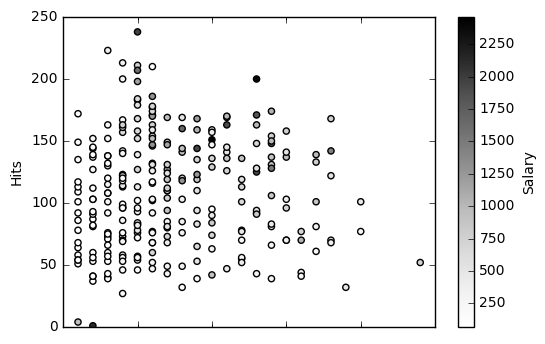

In [27]:
# scatter plot of Years versus Hits colored by Salary
hitters.plot(kind='scatter', x='Years', y='Hits', c='Salary', xlim=(0, 25), ylim=(0, 250))

In [28]:
# define features: exclude career statistics (which start with "C") and the response (Salary)
feature_cols = [h for h in hitters.columns if h[0] != 'C' and h != 'Salary']
feature_cols

['AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'League',
 'Division',
 'PutOuts',
 'Assists',
 'Errors',
 'NewLeague']

In [29]:
# define X and y
X = hitters[feature_cols]
y = hitters.Salary

## Predicting salary with a decision tree

Find the best **max_depth** for a decision tree using cross-validation:

In [30]:
# list of values to try for max_depth
max_depth_range = range(1, 21)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []

# use 10-fold cross-validation with each value of max_depth
from sklearn.cross_validation import cross_val_score
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=10, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

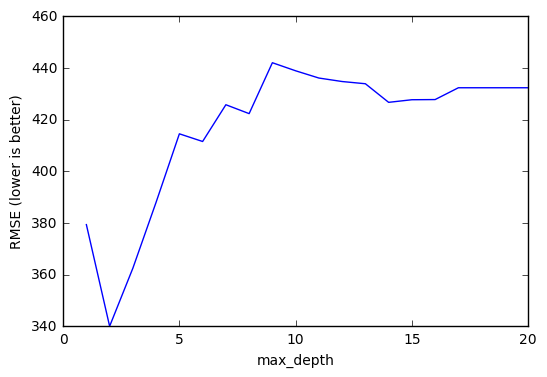

In [31]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

In [32]:
# show the best RMSE and the corresponding max_depth
sorted(zip(RMSE_scores, max_depth_range))[0]

(340.03416870475201, 2)

In [33]:
# max_depth=2 was best, so fit a tree using that parameter
treereg = DecisionTreeRegressor(max_depth=2, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

In [34]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_}).sort('importance')

/Users/sinanozdemir/anaconda/envs/sfdat28/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,feature,importance
0,AtBat,0.000000
2,HmRun,0.000000
3,Runs,0.000000
4,RBI,0.000000
5,Walks,0.000000
7,League,0.000000
8,Division,0.000000
9,PutOuts,0.000000
10,Assists,0.000000
11,Errors,0.000000


## Predicting salary with a Random Forest

In [35]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()
rfreg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

### Tuning n_estimators

One important tuning parameter is **n_estimators**, which is the number of trees that should be grown. It should be a large enough value that the error seems to have "stabilized".

In [36]:
# list of values to try for n_estimators
estimator_range = range(10, 310, 10)

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

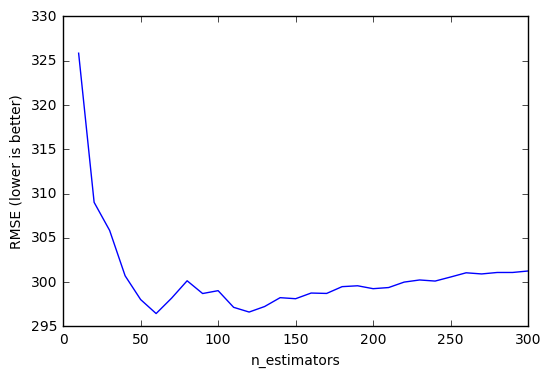

In [37]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')

### Tuning max_features

The other important tuning parameter is **max_features**, which is the number of features that should be considered at each split.

In [51]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average RMSE for each value of max_features
RMSE_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=10, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

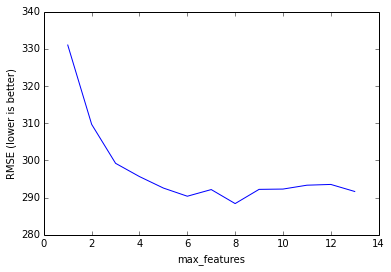

In [24]:
# plot max_features (x-axis) versus RMSE (y-axis)
plt.plot(feature_range, RMSE_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE (lower is better)')

In [ ]:
# show the best RMSE and the corresponding max_features
sorted(zip(RMSE_scores, feature_range))[0]

### Fitting a Random Forest with the best parameters

In [ ]:
# max_features=8 is best and n_estimators=150 is sufficiently large
rfreg = RandomForestRegressor(n_estimators=150, max_features=8, oob_score=True, random_state=1)
rfreg.fit(X, y)

In [ ]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort('importance')

In [ ]:
# compute the out-of-bag R-squared score
rfreg.oob_score_

### Reducing X to its most important features

In [29]:
# check the shape of X
X.shape

(263, 13)

In [30]:
# set a threshold for which features to include
print rfreg.transform(X, threshold=0.1).shape
print rfreg.transform(X, threshold='mean').shape
print rfreg.transform(X, threshold='median').shape

(263, 4)
(263, 5)
(263, 7)


In [31]:
# create a new feature matrix that only includes important features
X_important = rfreg.transform(X, threshold='mean')

In [32]:
# check the RMSE for a Random Forest that only includes important features
rfreg = RandomForestRegressor(n_estimators=150, max_features=3, random_state=1)
scores = cross_val_score(rfreg, X_important, y, cv=10, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

284.82790842153145

In [52]:
# check the RMSE for a Random Forest that includes ALL features ( for comparison )
rfreg = RandomForestRegressor(n_estimators=150, max_features=3, random_state=1)
scores = cross_val_score(rfreg, X, y, cv=10, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

297.64680677115257

## Comparing Random Forests with decision trees

**Advantages of Random Forests:**

- Performance is competitive with the best supervised learning methods
- Provides a more reliable estimate of feature importance
- Allows you to estimate out-of-sample error without using train/test split or cross-validation

**Disadvantages of Random Forests:**

- Less interpretable
- Slower to train
- Slower to predict

![Machine learning flowchart](images/driver_ensembling.png)

*Machine learning flowchart created by the [second place finisher](http://blog.kaggle.com/2015/04/20/axa-winners-interview-learning-telematic-fingerprints-from-gps-data/) of Kaggle's [Driver Telematics competition](https://www.kaggle.com/c/axa-driver-telematics-analysis)*

In [ ]:
# Plotting the Decision Boundary of four types of trees:
#     1. decision trees
#     2. random forest
#     4. ExtraTreesClassifier(http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier)
#     5. Adaboost (http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier)

('DecisionTree with features', [0, 1], 'has a score of', 0.92666666666666664)
('RandomForest with 30 estimators with features', [0, 1], 'has a score of', 0.92666666666666664)
('ExtraTrees with 30 estimators with features', [0, 1], 'has a score of', 0.92666666666666664)
('AdaBoost with 30 estimators with features', [0, 1], 'has a score of', 0.83999999999999997)
('DecisionTree with features', [0, 2], 'has a score of', 0.99333333333333329)
('RandomForest with 30 estimators with features', [0, 2], 'has a score of', 0.99333333333333329)
('ExtraTrees with 30 estimators with features', [0, 2], 'has a score of', 0.99333333333333329)
('AdaBoost with 30 estimators with features', [0, 2], 'has a score of', 0.99333333333333329)
('DecisionTree with features', [2, 3], 'has a score of', 0.99333333333333329)
('RandomForest with 30 estimators with features', [2, 3], 'has a score of', 0.99333333333333329)
('ExtraTrees with 30 estimators with features', [2, 3], 'has a score of', 0.99333333333333329)
('Ad

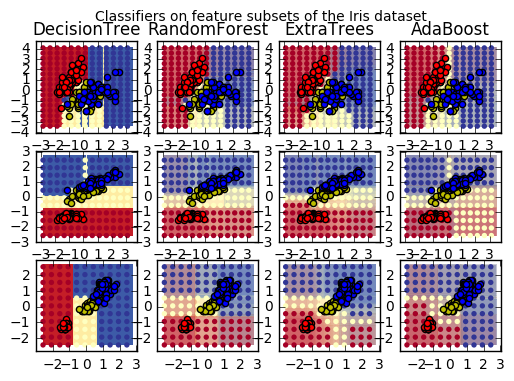

In [84]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import clone
from sklearn.datasets import load_iris
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.externals.six.moves import xrange
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
n_estimators = 30
plot_colors = "ryb"
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
iris = load_iris()

plot_idx = 1

models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators),
          ExtraTreesClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                             n_estimators=n_estimators)]

for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        clf = clone(model)
        clf = model.fit(X, y)

        scores = clf.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(len(model.estimators_))
        print( model_details + " with features", pair, "has a score of", scores )

        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a black outline
        xx_coarser, yy_coarser = np.meshgrid(np.arange(x_min, x_max, plot_step_coarser),
                                             np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(), yy_coarser.ravel()]).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15, c=Z_points_coarser, cmap=cmap, edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        for i, c in zip(xrange(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=c, label=iris.target_names[i],
                        cmap=cmap)

        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset")
plt.axis("tight")

plt.show()

In [132]:
# VotingClassifier is a manual ensembler
# It will take in several classifier models and have them duke it out
# You can either have them vote hard or soft
# A hard vote is like a ballot system, each model gets a set number of votes
# A soft vote includes models combing their predict_proba methods together


from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [133]:
# Breast Cancer Detection Dataset

In [134]:
breast_cancer = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', header=None)
breast_cancer.columns = ['ID', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']
breast_cancer.head()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [135]:
# They have ? where values are missing
breast_cancer[breast_cancer['Bare Nuclei']=='?'].head()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
23,1057013,8,4,5,1,2,?,7,3,1,4
40,1096800,6,6,6,9,6,?,7,8,1,2
139,1183246,1,1,1,1,1,?,2,1,1,2
145,1184840,1,1,3,1,2,?,2,1,1,2
158,1193683,1,1,2,1,3,?,1,1,1,2


In [136]:
breast_cancer.replace(to_replace='?', value=np.nan, inplace=True)
# replace ? with null values

breast_cancer.dropna(inplace=True)
# drop said null values

breast_cancer.isnull().sum()

ID                             0
Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

In [137]:
breast_cancer.shape

(683, 11)

In [138]:
breast_cancer['Class'].value_counts(normalize=True)
# score to beat is 65%

2    0.650073
4    0.349927
Name: Class, dtype: float64

In [173]:
X = breast_cancer.drop(['ID', 'Class'], axis=1)
y = breast_cancer.Class

In [176]:
models = [('rf', RandomForestClassifier(n_estimators=10)),
          ('decision', DecisionTreeClassifier(max_depth=3))
         ] 
# try a few models by themselves
for index, model in models:
    print index, np.mean(cross_val_score(model, X, y, cv=5, scoring='accuracy'))
    print
# each one can beat the null accuracy by itself

rf 0.964941876183

decision 0.935593403623



In [177]:
vc1 = VotingClassifier(models, voting='hard')
np.mean(cross_val_score(vc1, X, y, cv=5, scoring='accuracy'))

0.94295755609624232

In [178]:
vc2 = VotingClassifier(models, voting='soft')
np.mean(cross_val_score(vc2, X, y, cv=5, scoring='accuracy'))
# Neither of these are better than a single random forest!

0.9414328196809949

In [184]:
vc3 = VotingClassifier(models, voting='soft', weights=[2, 1])
np.mean(cross_val_score(vc1, X, y, cv=5, scoring='accuracy'))

0.94443903757772374

In [185]:
from sklearn.grid_search import GridSearchCV
params = {'voting':['soft', 'hard'], 'weights':[[1, 1], [2, 1], [1, 2]], 'rf__n_estimators':range(10,50,10), 'decision__max_depth':[None, 1, 2]}

In [186]:
grid = GridSearchCV(vc3, params, cv=5, scoring='accuracy')

In [187]:
# WARNING SUPER SLOWWWWWWW
# WARNING SUPER SLOWWWWWWW
grid.fit(X, y)  # WARNING SUPER SLOWWWWWWW # WARNING SUPER SLOWWWWWWW # WARNING SUPER SLOWWWWWWW 
# WARNING SUPER SLOWWWWWWW
# WARNING SUPER SLOWWWWWWW

GridSearchCV(cv=5, error_score='raise',
       estimator=VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            o...it=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))],
         voting='soft', weights=[2, 1]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'voting': ['soft', 'hard'], 'weights': [[1, 1], [2, 1], [1, 2]], 'rf__n_estimators': [10, 20, 30, 40], 'decision__max_depth': [None, 1, 2]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [188]:
grid.best_score_

# Ah there it is

0.96925329428989748

In [197]:
grid.best_params_

{'decision__max_depth': None,
 'rf__n_estimators': 40,
 'voting': 'hard',
 'weights': [2, 1]}

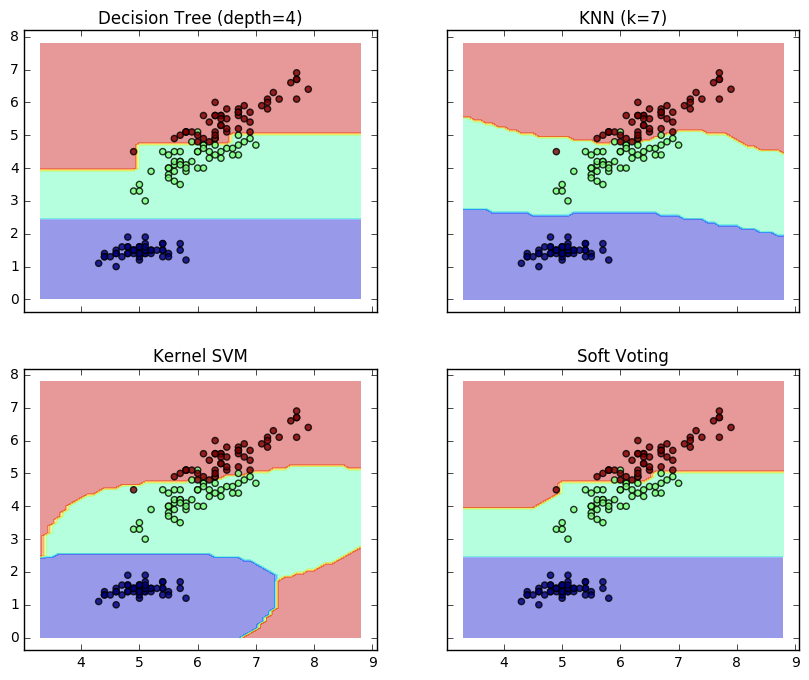

In [206]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()